In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import Libraries.dataloader as dl
from torchviz import make_dot
import random


import segmentation_models_pytorch as smp
from Libraries.dataloader import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
from PIL import Image
from IPython.display import display
import open3d as o3d

# Filter harmless warnings
import warnings
warnings.filterwarnings("ignore")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Transformations

class GaussianNoise(object):
    def __init__(self, p=0.5, mean=[0.0, 0.5], std=[1.0, 1.0]):
        self.p    = p
        self.std  = np.random.uniform(std[0],std[1])
        self.mean = np.random.uniform(mean[0],mean[1])
        
    def __call__(self, tensor):
        if random.random() < self.p:
            return tensor + torch.randn(tensor.size()) * self.std + self.mean
        else:
            return tensor 


DataAug = transforms.Compose([
    transforms.ColorJitter(
        brightness=[0.5,1.5],
        contrast=[0.5, 1.5],
        saturation=[0.5, 1.5],
        hue=[-0.1,0.1],
    ),
    transforms.GaussianBlur(
        kernel_size=3,
        sigma=(0.1, 9.0)
    ),
#     transforms.RandomErasing(
#         p=0.1,
#         scale=(0.01, 0.1),
#         ratio=(0.01, 3.3),
#         value=0,
#     ),
    GaussianNoise(
        p=0.2,
        mean=[0.0, 0.1],
        std=[0.01, 0.3]
    )
])

In [3]:
# Functions 
def CreatePointCloud(color_im, depth_im):
    color_raw = o3d.geometry.Image(np.uint8(color_im))
    depth_raw = o3d.geometry.Image(np.float32(depth_im))
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw, depth_raw, 10000) # 
    PointCloud = o3d.geometry.PointCloud.create_from_rgbd_image(
      rgbd_image,o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault)) # Creates Point Cloud from rgbd image
#     PointCloud.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]]) # Flip it, otherwise the pointcloud will be upside down
    return PointCloud

def CreateAxisCloud(depth_im):
    depth_raw  = o3d.geometry.Image(np.float32(depth_im/10)) # Converts depth data into image format
    PointCloud = o3d.geometry.PointCloud.create_from_depth_image(depth_raw,o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
    # PointCloud.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]]) # Flip it, otherwise the pointcloud will be upside down
    return PointCloud

def pick_points(pcd):
    vis = o3d.visualization.VisualizerWithEditing()
    vis.create_window()
    vis.add_geometry(pcd)
    vis.run()
    vis.destroy_window()
    numpy_array=np.asarray(pcd.points)
    point_id=vis.get_picked_points()

    return [numpy_array[point_id[0]],numpy_array[point_id[1]]]

def draw_arrow(pcd, points_real, points_extimated):
    lines=[[0,1],[2,3]]
    points = np.concatenate((points_real, points_extimated), axis=0)
    colors = [[1,0,0],[0,1,0]] # Red is REAL and Green is ESTIMATED
    line_set = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(points),
        lines=o3d.utility.Vector2iVector(lines),

    )
    line_set.colors=o3d.utility.Vector3dVector(colors)
    o3d.visualization.draw_geometries([pcd,line_set])

In [4]:
DATASET_ROOTDIR='/home/el_zlociako/Documents/Praca_inzynierska/Dataset/'
dl = DataLoader()
RGBD_in,axis_out = dl.load(DATASET_ROOTDIR, 'files/data.csv', 'S')

In [17]:
X_train, X_validation, y_train, y_validation = train_test_split(RGBD_in, axis_out, test_size=0.1)
X_train_aug = X_train.clone()

for i in range(X_train_aug.shape[0]):
     X_train_aug[i] = DataAug(X_train_aug[i])
        
y_train = torch.cat((y_train, y_train),axis=0)
X_train = torch.cat((X_train, X_train_aug),axis=0)

In [18]:
train_set = TensorDataset(X_train, y_train)
val_set = TensorDataset(X_validation, y_validation)

loader_args = dict(batch_size=4, num_workers=os.cpu_count(), pin_memory=True, drop_last=True)
train_loader = DataLoader(train_set,shuffle=True, **loader_args)
val_loader = DataLoader(val_set,shuffle=False, **loader_args)

In [19]:
# class AoRModel(nn.Module):
#     def __init__(self,pretrained=False ,input_channels=6, output_size=1):
#         super().__init__()
#         self.unet = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana',pretrained=False, scale=0.5)
#         self.unet.inc.double_conv[0] = nn.Conv2d(in_channels=input_channels, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
#         self.unet.outc.conv = nn.Conv2d(in_channels=64, out_channels=output_size, kernel_size=(1, 1), stride=(1, 1))
#     def forward(self, X):
#         return self.unet(X)

In [20]:
amp=False
device='cuda'

In [21]:
# Model = AoRModel().to(device)
# Model = UNet3D(n_channels=6, n_classes=1,trilinear=False).to(device)
Model = smp.Unet(in_channels=3, classes=1,encoder_weights=None,
                         encoder_name='timm-resnest50d').to(device)
print(Model)

Unet(
  (encoder): ResNestEncoder(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): ResNestBottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [22]:
# ModelCutter = AoRModel(input_channels=7).to(device)

In [23]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        inputs = F.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

In [24]:
criterion = smp.losses.DiceLoss(mode='binary')
# criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(Model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10) 

In [25]:
epochs = 80

train_losses = []
validation_losses = []

Model.train()
for epoch in range(epochs):
    # Run the training batches
    for batch, (images, true_mask) in enumerate(train_loader):
        batch+=1
        
        images = images.to(device=device)
        true_mask = true_mask.to(device=device)
        
        # Apply the model
        mask_prediction = Model(images)
        loss = criterion(mask_prediction, true_mask)
            
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if batch%1 == 0:
            print(f'epoch: {epoch+1:2}  batch: {batch}  loss: {loss.item():10.8f}')
    
    train_losses.append(loss.cpu().detach().numpy())
    scheduler.step(loss)
    
    # Run the validationing batches
    with torch.no_grad():
        for batch, (images, true_mask) in enumerate(val_loader):
            batch+=1

            images = images.to(device=device)
            true_mask = true_mask.to(device=device)

            # Apply the model
            mask_pred = Model(images)
            loss = criterion(mask_pred, true_mask)

    validation_losses.append(loss.cpu().detach().numpy())

epoch:  1  batch: 1  loss: 0.95328981
epoch:  1  batch: 2  loss: 0.97396106
epoch:  1  batch: 3  loss: 0.94367081
epoch:  1  batch: 4  loss: 0.95056629
epoch:  1  batch: 5  loss: 0.94016254
epoch:  1  batch: 6  loss: 0.93098092
epoch:  1  batch: 7  loss: 0.91275239
epoch:  1  batch: 8  loss: 0.94777799
epoch:  1  batch: 9  loss: 0.92612308
epoch:  1  batch: 10  loss: 0.94971204
epoch:  1  batch: 11  loss: 0.95694804
epoch:  1  batch: 12  loss: 0.90234208
epoch:  1  batch: 13  loss: 0.92473423
epoch:  1  batch: 14  loss: 0.92403388
epoch:  1  batch: 15  loss: 0.90209568
epoch:  1  batch: 16  loss: 0.88118523
epoch:  1  batch: 17  loss: 0.89674926
epoch:  1  batch: 18  loss: 0.91576755
epoch:  1  batch: 19  loss: 0.93603468
epoch:  1  batch: 20  loss: 0.92611301
epoch:  1  batch: 21  loss: 0.87921107
epoch:  1  batch: 22  loss: 0.89632154
epoch:  1  batch: 23  loss: 0.85848278
epoch:  1  batch: 24  loss: 0.87911296
epoch:  1  batch: 25  loss: 0.90888649
epoch:  1  batch: 26  loss: 0.8552

epoch:  4  batch: 5  loss: 0.27644336
epoch:  4  batch: 6  loss: 0.35304075
epoch:  4  batch: 7  loss: 0.58375931
epoch:  4  batch: 8  loss: -0.04957306
epoch:  4  batch: 9  loss: 0.24204981
epoch:  4  batch: 10  loss: 0.45516205
epoch:  4  batch: 11  loss: 0.28922230
epoch:  4  batch: 12  loss: 0.22971302
epoch:  4  batch: 13  loss: 0.49892336
epoch:  4  batch: 14  loss: 0.03014749
epoch:  4  batch: 15  loss: 0.09846878
epoch:  4  batch: 16  loss: 0.25444251
epoch:  4  batch: 17  loss: 0.23561800
epoch:  4  batch: 18  loss: 0.29584682
epoch:  4  batch: 19  loss: 0.48796928
epoch:  4  batch: 20  loss: 0.23204422
epoch:  4  batch: 21  loss: 0.08824199
epoch:  4  batch: 22  loss: -0.03324914
epoch:  4  batch: 23  loss: 0.32318449
epoch:  4  batch: 24  loss: 0.45294893
epoch:  4  batch: 25  loss: 0.06602752
epoch:  4  batch: 26  loss: -0.05320966
epoch:  4  batch: 27  loss: -0.02957499
epoch:  4  batch: 28  loss: 0.19551784
epoch:  4  batch: 29  loss: 0.15234989
epoch:  4  batch: 30  loss

epoch:  7  batch: 9  loss: 0.79043078
epoch:  7  batch: 10  loss: 0.07895869
epoch:  7  batch: 11  loss: 0.11609745
epoch:  7  batch: 12  loss: -0.00686383
epoch:  7  batch: 13  loss: -0.15343750
epoch:  7  batch: 14  loss: 0.31937444
epoch:  7  batch: 15  loss: 0.00536865
epoch:  7  batch: 16  loss: 0.15249699
epoch:  7  batch: 17  loss: 0.06705248
epoch:  7  batch: 18  loss: 0.04956025
epoch:  7  batch: 19  loss: -0.11197209
epoch:  7  batch: 20  loss: 0.03579009
epoch:  7  batch: 21  loss: 0.15316021
epoch:  7  batch: 22  loss: 0.18101585
epoch:  7  batch: 23  loss: -0.11321819
epoch:  7  batch: 24  loss: -0.18552637
epoch:  7  batch: 25  loss: -0.04851580
epoch:  7  batch: 26  loss: 0.03072870
epoch:  7  batch: 27  loss: 0.00211841
epoch:  7  batch: 28  loss: -0.10599029
epoch:  7  batch: 29  loss: -0.17653108
epoch:  7  batch: 30  loss: 0.05741704
epoch:  7  batch: 31  loss: 0.03745979
epoch:  7  batch: 32  loss: -0.02502489
epoch:  7  batch: 33  loss: 0.03763592
epoch:  7  batch:

epoch: 10  batch: 11  loss: -0.21373725
epoch: 10  batch: 12  loss: 0.09123075
epoch: 10  batch: 13  loss: -0.12469172
epoch: 10  batch: 14  loss: -0.04641402
epoch: 10  batch: 15  loss: 0.06912541
epoch: 10  batch: 16  loss: -0.03029954
epoch: 10  batch: 17  loss: -0.00435066
epoch: 10  batch: 18  loss: -0.09174073
epoch: 10  batch: 19  loss: -0.28800941
epoch: 10  batch: 20  loss: 0.06801385
epoch: 10  batch: 21  loss: -0.13527405
epoch: 10  batch: 22  loss: 0.29906595
epoch: 10  batch: 23  loss: 0.26084661
epoch: 10  batch: 24  loss: -0.24450076
epoch: 10  batch: 25  loss: -0.03195691
epoch: 10  batch: 26  loss: 0.10578513
epoch: 10  batch: 27  loss: -0.07589948
epoch: 10  batch: 28  loss: 0.02692884
epoch: 10  batch: 29  loss: 0.13370430
epoch: 10  batch: 30  loss: -0.09670234
epoch: 10  batch: 31  loss: -0.11070287
epoch: 10  batch: 32  loss: -0.21027434
epoch: 10  batch: 33  loss: -0.01535547
epoch: 10  batch: 34  loss: 0.12810743
epoch: 10  batch: 35  loss: -0.28850102
epoch: 10

epoch: 13  batch: 11  loss: -0.15567493
epoch: 13  batch: 12  loss: -0.21101689
epoch: 13  batch: 13  loss: -0.13063836
epoch: 13  batch: 14  loss: -0.25422180
epoch: 13  batch: 15  loss: -0.03387940
epoch: 13  batch: 16  loss: -0.16616118
epoch: 13  batch: 17  loss: -0.14015508
epoch: 13  batch: 18  loss: -0.13439977
epoch: 13  batch: 19  loss: -0.23393869
epoch: 13  batch: 20  loss: -0.16661954
epoch: 13  batch: 21  loss: -0.03947580
epoch: 13  batch: 22  loss: -0.08066773
epoch: 13  batch: 23  loss: -0.06700408
epoch: 13  batch: 24  loss: 0.01702756
epoch: 13  batch: 25  loss: -0.15856862
epoch: 13  batch: 26  loss: 0.27990967
epoch: 13  batch: 27  loss: -0.21069539
epoch: 13  batch: 28  loss: -0.27264893
epoch: 13  batch: 29  loss: -0.01096404
epoch: 13  batch: 30  loss: 0.07481438
epoch: 13  batch: 31  loss: 0.13229984
epoch: 13  batch: 32  loss: -0.08811975
epoch: 13  batch: 33  loss: -0.17627633
epoch: 13  batch: 34  loss: -0.24530733
epoch: 13  batch: 35  loss: -0.11428452
epoc

epoch: 16  batch: 11  loss: -0.02759588
epoch: 16  batch: 12  loss: -0.20841897
epoch: 16  batch: 13  loss: -0.11142814
epoch: 16  batch: 14  loss: -0.17960095
epoch: 16  batch: 15  loss: 0.07900381
epoch: 16  batch: 16  loss: -0.22730315
epoch: 16  batch: 17  loss: -0.23572767
epoch: 16  batch: 18  loss: -0.09762526
epoch: 16  batch: 19  loss: -0.14818668
epoch: 16  batch: 20  loss: -0.25402403
epoch: 16  batch: 21  loss: -0.06525826
epoch: 16  batch: 22  loss: -0.19822645
epoch: 16  batch: 23  loss: -0.21754444
epoch: 16  batch: 24  loss: -0.19459605
epoch: 16  batch: 25  loss: -0.31553161
epoch: 16  batch: 26  loss: -0.38132083
epoch: 16  batch: 27  loss: -0.14706779
epoch: 16  batch: 28  loss: 0.01863736
epoch: 16  batch: 29  loss: -0.14133382
epoch: 16  batch: 30  loss: -0.28224730
epoch: 16  batch: 31  loss: -0.15582025
epoch: 16  batch: 32  loss: -0.21887851
epoch: 16  batch: 33  loss: -0.19830060
epoch: 16  batch: 34  loss: -0.05373812
epoch: 16  batch: 35  loss: -0.06428444
ep

epoch: 19  batch: 11  loss: -0.24817967
epoch: 19  batch: 12  loss: -0.10429502
epoch: 19  batch: 13  loss: -0.25779498
epoch: 19  batch: 14  loss: -0.29498363
epoch: 19  batch: 15  loss: -0.31058395
epoch: 19  batch: 16  loss: -0.24894285
epoch: 19  batch: 17  loss: -0.18610656
epoch: 19  batch: 18  loss: -0.23244941
epoch: 19  batch: 19  loss: -0.35799778
epoch: 19  batch: 20  loss: -0.22599912
epoch: 19  batch: 21  loss: 0.01599962
epoch: 19  batch: 22  loss: -0.12451947
epoch: 19  batch: 23  loss: -0.15633726
epoch: 19  batch: 24  loss: -0.24716640
epoch: 19  batch: 25  loss: -0.23508751
epoch: 19  batch: 26  loss: -0.25872302
epoch: 19  batch: 27  loss: -0.28474534
epoch: 19  batch: 28  loss: -0.20743942
epoch: 19  batch: 29  loss: -0.16050088
epoch: 19  batch: 30  loss: -0.08299506
epoch: 19  batch: 31  loss: -0.20997524
epoch: 19  batch: 32  loss: -0.28032529
epoch: 19  batch: 33  loss: 0.13498360
epoch: 19  batch: 34  loss: -0.25855577
epoch: 19  batch: 35  loss: -0.06102276
ep

epoch: 22  batch: 11  loss: -0.25085294
epoch: 22  batch: 12  loss: -0.28629458
epoch: 22  batch: 13  loss: -0.25621188
epoch: 22  batch: 14  loss: -0.08878410
epoch: 22  batch: 15  loss: -0.08885884
epoch: 22  batch: 16  loss: -0.17213905
epoch: 22  batch: 17  loss: -0.25030315
epoch: 22  batch: 18  loss: -0.07099843
epoch: 22  batch: 19  loss: -0.29956865
epoch: 22  batch: 20  loss: -0.27875924
epoch: 22  batch: 21  loss: -0.02646720
epoch: 22  batch: 22  loss: -0.30359578
epoch: 22  batch: 23  loss: -0.35526669
epoch: 22  batch: 24  loss: -0.18958688
epoch: 22  batch: 25  loss: -0.23696971
epoch: 22  batch: 26  loss: -0.21330869
epoch: 22  batch: 27  loss: -0.23554552
epoch: 22  batch: 28  loss: -0.22311509
epoch: 22  batch: 29  loss: -0.25605917
epoch: 22  batch: 30  loss: 0.05740005
epoch: 22  batch: 31  loss: -0.30142152
epoch: 22  batch: 32  loss: -0.30847144
epoch: 22  batch: 33  loss: -0.06103170
epoch: 22  batch: 34  loss: -0.24268281
epoch: 22  batch: 35  loss: -0.24869728
e

epoch: 25  batch: 11  loss: -0.19893956
epoch: 25  batch: 12  loss: -0.27974248
epoch: 25  batch: 13  loss: -0.23865211
epoch: 25  batch: 14  loss: -0.26506686
epoch: 25  batch: 15  loss: -0.17272592
epoch: 25  batch: 16  loss: -0.24730170
epoch: 25  batch: 17  loss: -0.26870549
epoch: 25  batch: 18  loss: -0.21987820
epoch: 25  batch: 19  loss: -0.33922696
epoch: 25  batch: 20  loss: -0.16521502
epoch: 25  batch: 21  loss: -0.21572459
epoch: 25  batch: 22  loss: -0.11413348
epoch: 25  batch: 23  loss: -0.18880093
epoch: 25  batch: 24  loss: -0.26739311
epoch: 25  batch: 25  loss: -0.16308570
epoch: 25  batch: 26  loss: -0.31816185
epoch: 25  batch: 27  loss: -0.38198996
epoch: 25  batch: 28  loss: 0.25485414
epoch: 25  batch: 29  loss: -0.20468891
epoch: 25  batch: 30  loss: -0.26099300
epoch: 25  batch: 31  loss: -0.31060970
epoch: 25  batch: 32  loss: 0.00009352
epoch: 25  batch: 33  loss: -0.19792390
epoch: 25  batch: 34  loss: -0.29407382
epoch: 25  batch: 35  loss: -0.21519148
ep

epoch: 28  batch: 11  loss: -0.23586273
epoch: 28  batch: 12  loss: -0.26468062
epoch: 28  batch: 13  loss: -0.20460224
epoch: 28  batch: 14  loss: -0.04484236
epoch: 28  batch: 15  loss: -0.27252567
epoch: 28  batch: 16  loss: -0.12957716
epoch: 28  batch: 17  loss: -0.18899465
epoch: 28  batch: 18  loss: -0.38482547
epoch: 28  batch: 19  loss: -0.22491848
epoch: 28  batch: 20  loss: -0.28185868
epoch: 28  batch: 21  loss: -0.24705589
epoch: 28  batch: 22  loss: -0.21247077
epoch: 28  batch: 23  loss: -0.23485494
epoch: 28  batch: 24  loss: -0.28662014
epoch: 28  batch: 25  loss: -0.31263983
epoch: 28  batch: 26  loss: -0.22019327
epoch: 28  batch: 27  loss: -0.19613540
epoch: 28  batch: 28  loss: 0.30219465
epoch: 28  batch: 29  loss: -0.15802193
epoch: 28  batch: 30  loss: -0.28366899
epoch: 28  batch: 31  loss: -0.24345243
epoch: 28  batch: 32  loss: -0.24182284
epoch: 28  batch: 33  loss: -0.23336339
epoch: 28  batch: 34  loss: -0.24355638
epoch: 28  batch: 35  loss: -0.24024999
e

epoch: 31  batch: 11  loss: -0.24651206
epoch: 31  batch: 12  loss: -0.33713794
epoch: 31  batch: 13  loss: -0.25718832
epoch: 31  batch: 14  loss: -0.29623067
epoch: 31  batch: 15  loss: -0.26892221
epoch: 31  batch: 16  loss: -0.16896307
epoch: 31  batch: 17  loss: -0.18056762
epoch: 31  batch: 18  loss: -0.11863148
epoch: 31  batch: 19  loss: -0.30657256
epoch: 31  batch: 20  loss: -0.32760453
epoch: 31  batch: 21  loss: -0.23412132
epoch: 31  batch: 22  loss: -0.27129543
epoch: 31  batch: 23  loss: -0.20366621
epoch: 31  batch: 24  loss: -0.24008739
epoch: 31  batch: 25  loss: -0.27382183
epoch: 31  batch: 26  loss: -0.28360260
epoch: 31  batch: 27  loss: -0.35178995
epoch: 31  batch: 28  loss: -0.10163820
epoch: 31  batch: 29  loss: -0.30833113
epoch: 31  batch: 30  loss: -0.20356357
epoch: 31  batch: 31  loss: -0.25049424
epoch: 31  batch: 32  loss: -0.17584503
epoch: 31  batch: 33  loss: -0.22218704
epoch: 31  batch: 34  loss: -0.28365552
epoch: 31  batch: 35  loss: -0.32344675


epoch: 34  batch: 11  loss: -0.27337348
epoch: 34  batch: 12  loss: -0.32761216
epoch: 34  batch: 13  loss: -0.25157225
epoch: 34  batch: 14  loss: -0.31690371
epoch: 34  batch: 15  loss: -0.27299929
epoch: 34  batch: 16  loss: -0.09001791
epoch: 34  batch: 17  loss: -0.28832030
epoch: 34  batch: 18  loss: -0.13497043
epoch: 34  batch: 19  loss: -0.16147470
epoch: 34  batch: 20  loss: -0.21116006
epoch: 34  batch: 21  loss: 0.00384516
epoch: 34  batch: 22  loss: -0.26054299
epoch: 34  batch: 23  loss: -0.27539730
epoch: 34  batch: 24  loss: -0.17506707
epoch: 34  batch: 25  loss: -0.28234434
epoch: 34  batch: 26  loss: -0.13263142
epoch: 34  batch: 27  loss: -0.13368464
epoch: 34  batch: 28  loss: -0.28426087
epoch: 34  batch: 29  loss: -0.20383632
epoch: 34  batch: 30  loss: -0.17236590
epoch: 34  batch: 31  loss: -0.22607183
epoch: 34  batch: 32  loss: -0.34356785
epoch: 34  batch: 33  loss: -0.21543431
epoch: 34  batch: 34  loss: -0.30666506
epoch: 34  batch: 35  loss: -0.13124037
e

epoch: 37  batch: 11  loss: -0.25011230
epoch: 37  batch: 12  loss: -0.26568985
epoch: 37  batch: 13  loss: 0.04598612
epoch: 37  batch: 14  loss: -0.26704276
epoch: 37  batch: 15  loss: -0.14717948
epoch: 37  batch: 16  loss: -0.33805001
epoch: 37  batch: 17  loss: -0.31286383
epoch: 37  batch: 18  loss: -0.26517963
epoch: 37  batch: 19  loss: -0.29190183
epoch: 37  batch: 20  loss: -0.20519304
epoch: 37  batch: 21  loss: -0.30573237
epoch: 37  batch: 22  loss: -0.17451990
epoch: 37  batch: 23  loss: -0.09195328
epoch: 37  batch: 24  loss: -0.19857657
epoch: 37  batch: 25  loss: -0.28584909
epoch: 37  batch: 26  loss: -0.32253373
epoch: 37  batch: 27  loss: -0.38627696
epoch: 37  batch: 28  loss: -0.14095438
epoch: 37  batch: 29  loss: -0.14327586
epoch: 37  batch: 30  loss: -0.28178537
epoch: 37  batch: 31  loss: -0.20628750
epoch: 37  batch: 32  loss: -0.32199895
epoch: 37  batch: 33  loss: -0.22017360
epoch: 37  batch: 34  loss: -0.10950148
epoch: 37  batch: 35  loss: -0.34931946
e

epoch: 40  batch: 11  loss: -0.23583078
epoch: 40  batch: 12  loss: -0.21803665
epoch: 40  batch: 13  loss: -0.19352114
epoch: 40  batch: 14  loss: -0.35476577
epoch: 40  batch: 15  loss: -0.14229405
epoch: 40  batch: 16  loss: -0.17722261
epoch: 40  batch: 17  loss: -0.28107166
epoch: 40  batch: 18  loss: -0.29693925
epoch: 40  batch: 19  loss: -0.18828452
epoch: 40  batch: 20  loss: -0.30992627
epoch: 40  batch: 21  loss: -0.29930735
epoch: 40  batch: 22  loss: -0.18181741
epoch: 40  batch: 23  loss: -0.24777389
epoch: 40  batch: 24  loss: -0.29435503
epoch: 40  batch: 25  loss: -0.27781761
epoch: 40  batch: 26  loss: -0.32179308
epoch: 40  batch: 27  loss: -0.35537565
epoch: 40  batch: 28  loss: -0.32108378
epoch: 40  batch: 29  loss: -0.15647745
epoch: 40  batch: 30  loss: -0.25044835
epoch: 40  batch: 31  loss: 0.06593084
epoch: 40  batch: 32  loss: -0.25295889
epoch: 40  batch: 33  loss: -0.05819845
epoch: 40  batch: 34  loss: -0.31313312
epoch: 40  batch: 35  loss: -0.31203330
e

epoch: 43  batch: 11  loss: -0.19163394
epoch: 43  batch: 12  loss: -0.21052027
epoch: 43  batch: 13  loss: -0.26542854
epoch: 43  batch: 14  loss: -0.23018968
epoch: 43  batch: 15  loss: -0.21142185
epoch: 43  batch: 16  loss: -0.19260800
epoch: 43  batch: 17  loss: -0.26822269
epoch: 43  batch: 18  loss: -0.17551517
epoch: 43  batch: 19  loss: -0.24347115
epoch: 43  batch: 20  loss: -0.17114699
epoch: 43  batch: 21  loss: -0.29092503
epoch: 43  batch: 22  loss: -0.25081503
epoch: 43  batch: 23  loss: -0.13657975
epoch: 43  batch: 24  loss: -0.28990495
epoch: 43  batch: 25  loss: -0.34389174
epoch: 43  batch: 26  loss: -0.19115472
epoch: 43  batch: 27  loss: -0.13604832
epoch: 43  batch: 28  loss: -0.13505912
epoch: 43  batch: 29  loss: -0.09365630
epoch: 43  batch: 30  loss: -0.32918823
epoch: 43  batch: 31  loss: -0.30828667
epoch: 43  batch: 32  loss: -0.29002512
epoch: 43  batch: 33  loss: -0.31264436
epoch: 43  batch: 34  loss: -0.31582391
epoch: 43  batch: 35  loss: -0.15077817


epoch: 46  batch: 11  loss: -0.20948660
epoch: 46  batch: 12  loss: -0.27673578
epoch: 46  batch: 13  loss: -0.00747204
epoch: 46  batch: 14  loss: -0.27323258
epoch: 46  batch: 15  loss: -0.13641095
epoch: 46  batch: 16  loss: -0.32371926
epoch: 46  batch: 17  loss: -0.22387481
epoch: 46  batch: 18  loss: -0.20945096
epoch: 46  batch: 19  loss: -0.24404252
epoch: 46  batch: 20  loss: -0.20662260
epoch: 46  batch: 21  loss: -0.13325036
epoch: 46  batch: 22  loss: -0.29728568
epoch: 46  batch: 23  loss: -0.26474321
epoch: 46  batch: 24  loss: -0.22422528
epoch: 46  batch: 25  loss: -0.25136960
epoch: 46  batch: 26  loss: -0.25141323
epoch: 46  batch: 27  loss: -0.08379579
epoch: 46  batch: 28  loss: -0.34209490
epoch: 46  batch: 29  loss: -0.20109296
epoch: 46  batch: 30  loss: -0.17850745
epoch: 46  batch: 31  loss: -0.23751712
epoch: 46  batch: 32  loss: -0.13961685
epoch: 46  batch: 33  loss: -0.28862882
epoch: 46  batch: 34  loss: -0.29210162
epoch: 46  batch: 35  loss: -0.24533081


epoch: 49  batch: 11  loss: -0.07828212
epoch: 49  batch: 12  loss: -0.13380122
epoch: 49  batch: 13  loss: -0.12226355
epoch: 49  batch: 14  loss: -0.22169757
epoch: 49  batch: 15  loss: -0.22499049
epoch: 49  batch: 16  loss: -0.20194173
epoch: 49  batch: 17  loss: -0.17230749
epoch: 49  batch: 18  loss: -0.22042060
epoch: 49  batch: 19  loss: -0.01436377
epoch: 49  batch: 20  loss: -0.17332578
epoch: 49  batch: 21  loss: -0.26665831
epoch: 49  batch: 22  loss: -0.21699560
epoch: 49  batch: 23  loss: -0.35804558
epoch: 49  batch: 24  loss: -0.29474318
epoch: 49  batch: 25  loss: -0.27905118
epoch: 49  batch: 26  loss: -0.29973006
epoch: 49  batch: 27  loss: -0.27822542
epoch: 49  batch: 28  loss: -0.11842763
epoch: 49  batch: 29  loss: -0.20406997
epoch: 49  batch: 30  loss: -0.27111697
epoch: 49  batch: 31  loss: -0.27352703
epoch: 49  batch: 32  loss: -0.28667438
epoch: 49  batch: 33  loss: -0.37081718
epoch: 49  batch: 34  loss: -0.26559591
epoch: 49  batch: 35  loss: -0.22202587


epoch: 52  batch: 11  loss: -0.28865159
epoch: 52  batch: 12  loss: -0.23045349
epoch: 52  batch: 13  loss: -0.30273366
epoch: 52  batch: 14  loss: -0.16416204
epoch: 52  batch: 15  loss: -0.30040598
epoch: 52  batch: 16  loss: -0.17027211
epoch: 52  batch: 17  loss: -0.09964907
epoch: 52  batch: 18  loss: -0.28559017
epoch: 52  batch: 19  loss: -0.29401469
epoch: 52  batch: 20  loss: -0.19976091
epoch: 52  batch: 21  loss: -0.26875603
epoch: 52  batch: 22  loss: 0.22874230
epoch: 52  batch: 23  loss: -0.24308527
epoch: 52  batch: 24  loss: -0.27180231
epoch: 52  batch: 25  loss: -0.22031212
epoch: 52  batch: 26  loss: -0.29957771
epoch: 52  batch: 27  loss: -0.23807144
epoch: 52  batch: 28  loss: -0.21334803
epoch: 52  batch: 29  loss: -0.28913236
epoch: 52  batch: 30  loss: -0.31469452
epoch: 52  batch: 31  loss: -0.28245437
epoch: 52  batch: 32  loss: -0.28743839
epoch: 52  batch: 33  loss: -0.26622069
epoch: 52  batch: 34  loss: -0.32784843
epoch: 52  batch: 35  loss: -0.36164284
e

epoch: 55  batch: 11  loss: -0.20295095
epoch: 55  batch: 12  loss: -0.33732760
epoch: 55  batch: 13  loss: -0.20950556
epoch: 55  batch: 14  loss: -0.31545615
epoch: 55  batch: 15  loss: -0.30081558
epoch: 55  batch: 16  loss: -0.24165833
epoch: 55  batch: 17  loss: -0.26226914
epoch: 55  batch: 18  loss: -0.28957498
epoch: 55  batch: 19  loss: -0.33484399
epoch: 55  batch: 20  loss: -0.27249014
epoch: 55  batch: 21  loss: 0.00226736
epoch: 55  batch: 22  loss: -0.41344392
epoch: 55  batch: 23  loss: -0.03139663
epoch: 55  batch: 24  loss: -0.33280921
epoch: 55  batch: 25  loss: -0.30995786
epoch: 55  batch: 26  loss: -0.25333285
epoch: 55  batch: 27  loss: -0.35343361
epoch: 55  batch: 28  loss: 0.14548600
epoch: 55  batch: 29  loss: -0.28231156
epoch: 55  batch: 30  loss: -0.27731562
epoch: 55  batch: 31  loss: -0.23045897
epoch: 55  batch: 32  loss: -0.28303301
epoch: 55  batch: 33  loss: -0.37058568
epoch: 55  batch: 34  loss: -0.17214012
epoch: 55  batch: 35  loss: -0.34839630
ep

epoch: 58  batch: 11  loss: -0.24624789
epoch: 58  batch: 12  loss: -0.33025813
epoch: 58  batch: 13  loss: -0.20771050
epoch: 58  batch: 14  loss: -0.28548551
epoch: 58  batch: 15  loss: -0.21482396
epoch: 58  batch: 16  loss: -0.36607289
epoch: 58  batch: 17  loss: -0.44409442
epoch: 58  batch: 18  loss: -0.18007088
epoch: 58  batch: 19  loss: -0.26747847
epoch: 58  batch: 20  loss: -0.38180888
epoch: 58  batch: 21  loss: -0.26049697
epoch: 58  batch: 22  loss: -0.35540617
epoch: 58  batch: 23  loss: -0.16335511
epoch: 58  batch: 24  loss: -0.32851505
epoch: 58  batch: 25  loss: -0.29809034
epoch: 58  batch: 26  loss: -0.29427195
epoch: 58  batch: 27  loss: -0.35397279
epoch: 58  batch: 28  loss: 0.05096966
epoch: 58  batch: 29  loss: -0.21852052
epoch: 58  batch: 30  loss: -0.30990958
epoch: 58  batch: 31  loss: -0.26992118
epoch: 58  batch: 32  loss: -0.16236472
epoch: 58  batch: 33  loss: -0.22977984
epoch: 58  batch: 34  loss: -0.29999602
epoch: 58  batch: 35  loss: -0.34251368
e

epoch: 61  batch: 11  loss: -0.34158707
epoch: 61  batch: 12  loss: -0.35047638
epoch: 61  batch: 13  loss: -0.17127681
epoch: 61  batch: 14  loss: -0.26993382
epoch: 61  batch: 15  loss: -0.34644794
epoch: 61  batch: 16  loss: -0.32270527
epoch: 61  batch: 17  loss: -0.29267836
epoch: 61  batch: 18  loss: 0.06082249
epoch: 61  batch: 19  loss: -0.33668768
epoch: 61  batch: 20  loss: -0.20962477
epoch: 61  batch: 21  loss: -0.36454868
epoch: 61  batch: 22  loss: -0.34644961
epoch: 61  batch: 23  loss: -0.20012724
epoch: 61  batch: 24  loss: -0.24494004
epoch: 61  batch: 25  loss: -0.30067134
epoch: 61  batch: 26  loss: -0.33830285
epoch: 61  batch: 27  loss: -0.27835608
epoch: 61  batch: 28  loss: -0.34061170
epoch: 61  batch: 29  loss: -0.28346479
epoch: 61  batch: 30  loss: -0.35479891
epoch: 61  batch: 31  loss: -0.14431405
epoch: 61  batch: 32  loss: -0.27678514
epoch: 61  batch: 33  loss: -0.30986297
epoch: 61  batch: 34  loss: -0.37196481
epoch: 61  batch: 35  loss: -0.10594594
e

epoch: 64  batch: 11  loss: -0.19814217
epoch: 64  batch: 12  loss: -0.22942555
epoch: 64  batch: 13  loss: -0.25286794
epoch: 64  batch: 14  loss: -0.35372543
epoch: 64  batch: 15  loss: -0.29631984
epoch: 64  batch: 16  loss: -0.34242380
epoch: 64  batch: 17  loss: -0.25533199
epoch: 64  batch: 18  loss: -0.23167503
epoch: 64  batch: 19  loss: -0.26705897
epoch: 64  batch: 20  loss: -0.31797075
epoch: 64  batch: 21  loss: -0.29404604
epoch: 64  batch: 22  loss: -0.33834314
epoch: 64  batch: 23  loss: -0.27458823
epoch: 64  batch: 24  loss: -0.22443855
epoch: 64  batch: 25  loss: -0.33070731
epoch: 64  batch: 26  loss: -0.25852430
epoch: 64  batch: 27  loss: -0.31587052
epoch: 64  batch: 28  loss: -0.21107185
epoch: 64  batch: 29  loss: -0.28665233
epoch: 64  batch: 30  loss: -0.26106703
epoch: 64  batch: 31  loss: -0.26066720
epoch: 64  batch: 32  loss: -0.20218384
epoch: 64  batch: 33  loss: -0.36838114
epoch: 64  batch: 34  loss: -0.34817672
epoch: 64  batch: 35  loss: -0.18144619


epoch: 67  batch: 11  loss: -0.25037014
epoch: 67  batch: 12  loss: -0.30216002
epoch: 67  batch: 13  loss: -0.34888995
epoch: 67  batch: 14  loss: -0.35846269
epoch: 67  batch: 15  loss: -0.40390146
epoch: 67  batch: 16  loss: -0.27931392
epoch: 67  batch: 17  loss: -0.32215917
epoch: 67  batch: 18  loss: -0.21083272
epoch: 67  batch: 19  loss: -0.32396710
epoch: 67  batch: 20  loss: -0.31705558
epoch: 67  batch: 21  loss: -0.20267808
epoch: 67  batch: 22  loss: -0.23411572
epoch: 67  batch: 23  loss: -0.37097025
epoch: 67  batch: 24  loss: -0.35366714
epoch: 67  batch: 25  loss: -0.27151299
epoch: 67  batch: 26  loss: -0.28546178
epoch: 67  batch: 27  loss: -0.15525448
epoch: 67  batch: 28  loss: -0.36958575
epoch: 67  batch: 29  loss: -0.40199602
epoch: 67  batch: 30  loss: -0.26874542
epoch: 67  batch: 31  loss: -0.36223626
epoch: 67  batch: 32  loss: -0.31875837
epoch: 67  batch: 33  loss: 0.04730248
epoch: 67  batch: 34  loss: -0.23516703
epoch: 67  batch: 35  loss: -0.28853023
e

epoch: 70  batch: 11  loss: -0.21813929
epoch: 70  batch: 12  loss: -0.26946485
epoch: 70  batch: 13  loss: -0.22286332
epoch: 70  batch: 14  loss: -0.13786268
epoch: 70  batch: 15  loss: -0.26574743
epoch: 70  batch: 16  loss: -0.17427945
epoch: 70  batch: 17  loss: -0.25065458
epoch: 70  batch: 18  loss: -0.22948039
epoch: 70  batch: 19  loss: -0.34152830
epoch: 70  batch: 20  loss: -0.29353392
epoch: 70  batch: 21  loss: -0.36367631
epoch: 70  batch: 22  loss: -0.25997901
epoch: 70  batch: 23  loss: -0.33567870
epoch: 70  batch: 24  loss: -0.22934616
epoch: 70  batch: 25  loss: -0.24650347
epoch: 70  batch: 26  loss: -0.33102274
epoch: 70  batch: 27  loss: -0.32480943
epoch: 70  batch: 28  loss: -0.37570322
epoch: 70  batch: 29  loss: -0.27623808
epoch: 70  batch: 30  loss: -0.28946066
epoch: 70  batch: 31  loss: 0.24635512
epoch: 70  batch: 32  loss: -0.35877907
epoch: 70  batch: 33  loss: -0.27118516
epoch: 70  batch: 34  loss: -0.17613518
epoch: 70  batch: 35  loss: -0.25692749
e

epoch: 73  batch: 11  loss: -0.32148206
epoch: 73  batch: 12  loss: -0.27936983
epoch: 73  batch: 13  loss: -0.30857134
epoch: 73  batch: 14  loss: -0.31753457
epoch: 73  batch: 15  loss: -0.25993776
epoch: 73  batch: 16  loss: -0.15543592
epoch: 73  batch: 17  loss: -0.35232782
epoch: 73  batch: 18  loss: -0.24898207
epoch: 73  batch: 19  loss: -0.34546721
epoch: 73  batch: 20  loss: -0.24487698
epoch: 73  batch: 21  loss: -0.19074392
epoch: 73  batch: 22  loss: -0.31747854
epoch: 73  batch: 23  loss: -0.35012555
epoch: 73  batch: 24  loss: -0.34368420
epoch: 73  batch: 25  loss: -0.25060439
epoch: 73  batch: 26  loss: -0.27301657
epoch: 73  batch: 27  loss: -0.25091374
epoch: 73  batch: 28  loss: -0.20779347
epoch: 73  batch: 29  loss: -0.18189418
epoch: 73  batch: 30  loss: -0.27873087
epoch: 73  batch: 31  loss: -0.27056515
epoch: 73  batch: 32  loss: -0.32760096
epoch: 73  batch: 33  loss: -0.34628069
epoch: 73  batch: 34  loss: -0.32987559
epoch: 73  batch: 35  loss: -0.22891521


epoch: 76  batch: 11  loss: -0.27088130
epoch: 76  batch: 12  loss: -0.26643467
epoch: 76  batch: 13  loss: -0.34848237
epoch: 76  batch: 14  loss: -0.21077013
epoch: 76  batch: 15  loss: -0.32965946
epoch: 76  batch: 16  loss: -0.06459343
epoch: 76  batch: 17  loss: -0.28485823
epoch: 76  batch: 18  loss: -0.29519629
epoch: 76  batch: 19  loss: -0.27896392
epoch: 76  batch: 20  loss: -0.37900627
epoch: 76  batch: 21  loss: -0.15805423
epoch: 76  batch: 22  loss: -0.29579830
epoch: 76  batch: 23  loss: -0.32745862
epoch: 76  batch: 24  loss: -0.22950161
epoch: 76  batch: 25  loss: -0.31620634
epoch: 76  batch: 26  loss: -0.41775799
epoch: 76  batch: 27  loss: -0.37970376
epoch: 76  batch: 28  loss: -0.30897129
epoch: 76  batch: 29  loss: -0.31458950
epoch: 76  batch: 30  loss: -0.24518108
epoch: 76  batch: 31  loss: -0.15145481
epoch: 76  batch: 32  loss: -0.14395690
epoch: 76  batch: 33  loss: -0.35097563
epoch: 76  batch: 34  loss: -0.21734381
epoch: 76  batch: 35  loss: -0.26818812


epoch: 79  batch: 11  loss: -0.25121033
epoch: 79  batch: 12  loss: -0.36365461
epoch: 79  batch: 13  loss: -0.32878494
epoch: 79  batch: 14  loss: -0.29798543
epoch: 79  batch: 15  loss: -0.22954953
epoch: 79  batch: 16  loss: -0.29609060
epoch: 79  batch: 17  loss: -0.34161079
epoch: 79  batch: 18  loss: -0.33408678
epoch: 79  batch: 19  loss: -0.19767678
epoch: 79  batch: 20  loss: -0.33266544
epoch: 79  batch: 21  loss: -0.33201587
epoch: 79  batch: 22  loss: -0.26984942
epoch: 79  batch: 23  loss: -0.24635410
epoch: 79  batch: 24  loss: -0.26174927
epoch: 79  batch: 25  loss: -0.18455124
epoch: 79  batch: 26  loss: -0.21487617
epoch: 79  batch: 27  loss: -0.26026785
epoch: 79  batch: 28  loss: -0.14212370
epoch: 79  batch: 29  loss: -0.30409575
epoch: 79  batch: 30  loss: -0.27034605
epoch: 79  batch: 31  loss: -0.22593355
epoch: 79  batch: 32  loss: -0.26761818
epoch: 79  batch: 33  loss: -0.36360908
epoch: 79  batch: 34  loss: -0.20660007
epoch: 79  batch: 35  loss: -0.14881480


Text(0, 0.5, 'Loss')

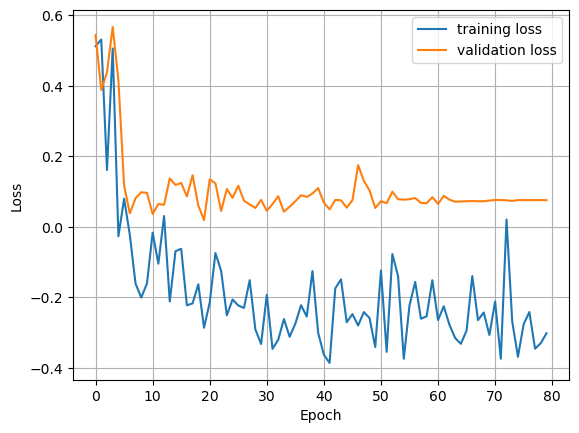

In [26]:
plt.plot(train_losses, label='training loss')
plt.plot(validation_losses, label='validation loss')
plt.legend();
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [27]:
# Model = AoRModel().to(device)
# Model.load_state_dict(torch.load('Modele/Unet_3in1out_DiceLoss_Loss001_Enc_timm-resnest50d_80Epoch_0_GoodOne.pt'))
Model.eval()

Unet(
  (encoder): ResNestEncoder(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): ResNestBottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [28]:
inv_resize = transforms.Resize([480,640], interpolation=transforms.InterpolationMode.NEAREST)

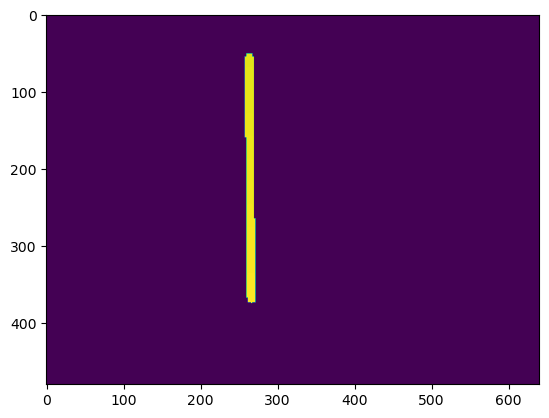

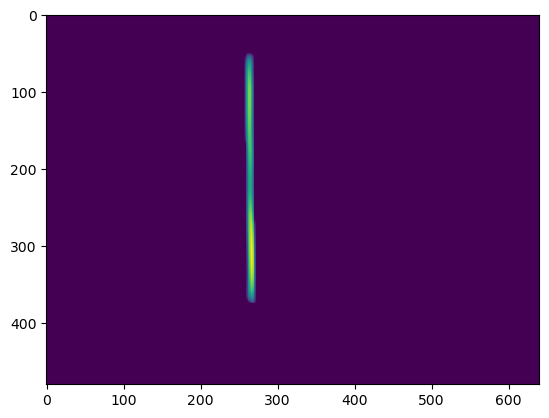

------------------------------------------------------------


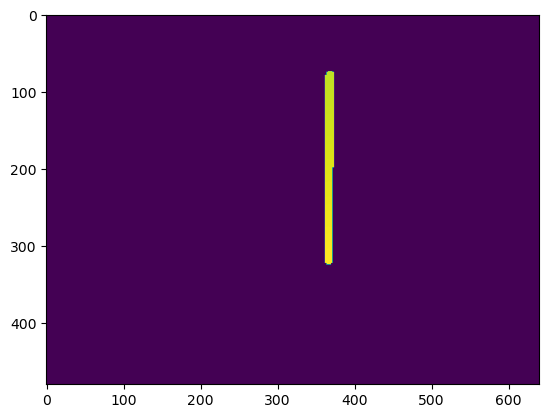

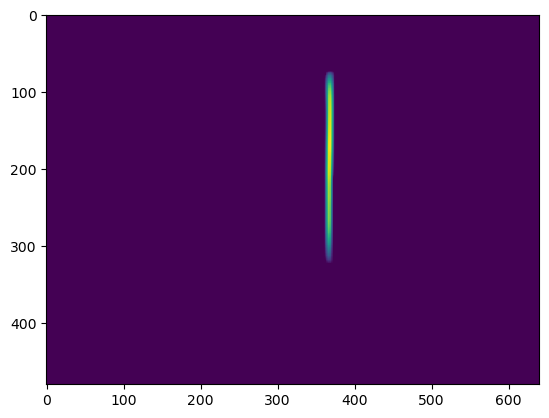

------------------------------------------------------------


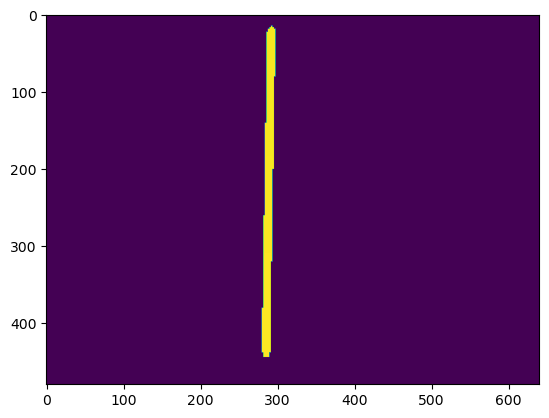

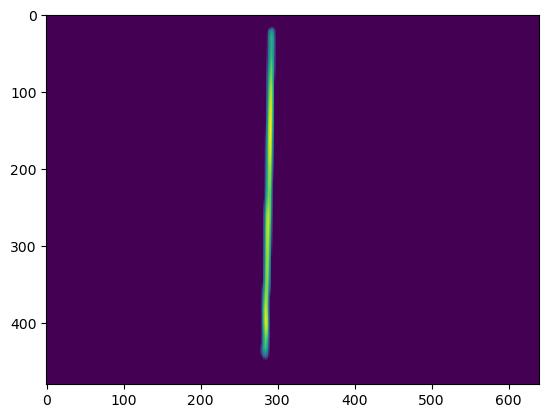

------------------------------------------------------------


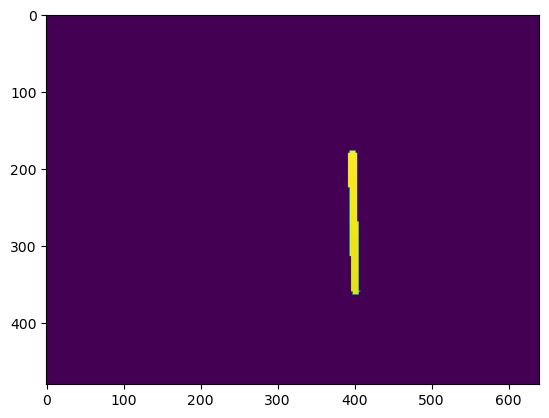

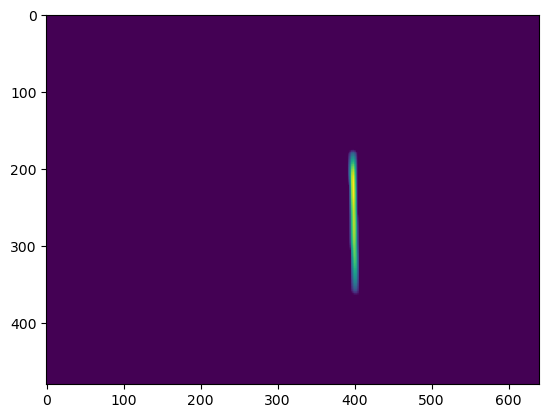

------------------------------------------------------------


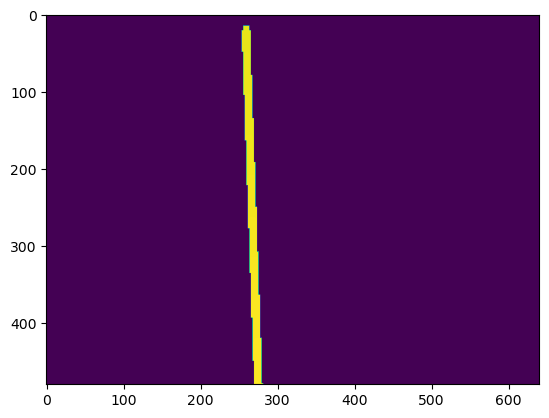

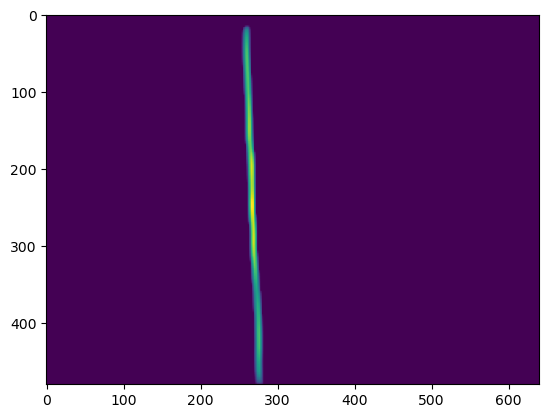

------------------------------------------------------------


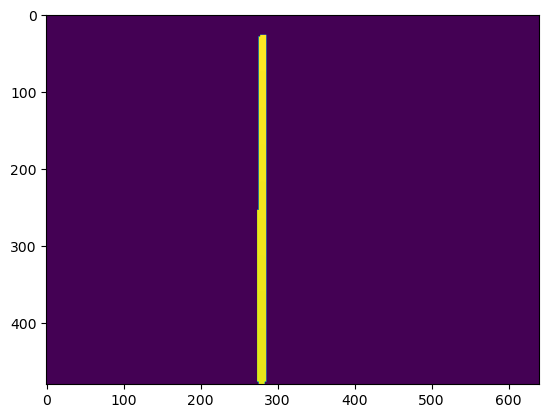

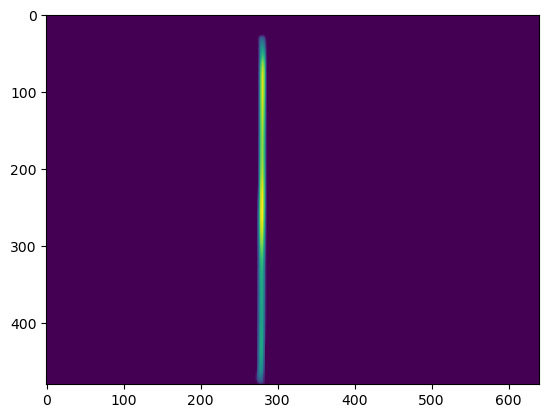

------------------------------------------------------------


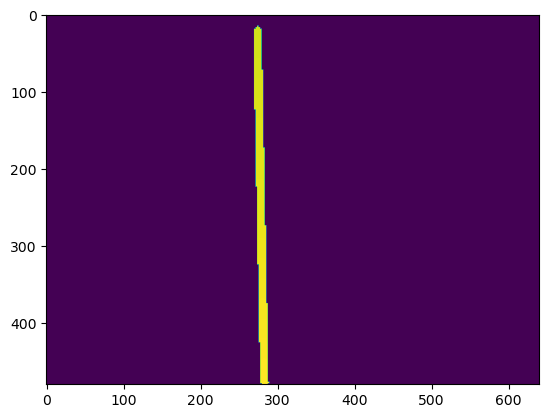

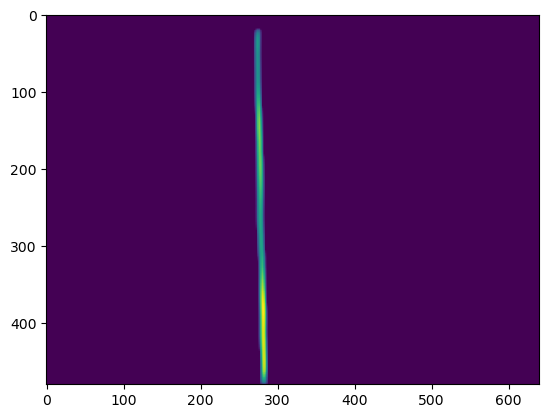

------------------------------------------------------------


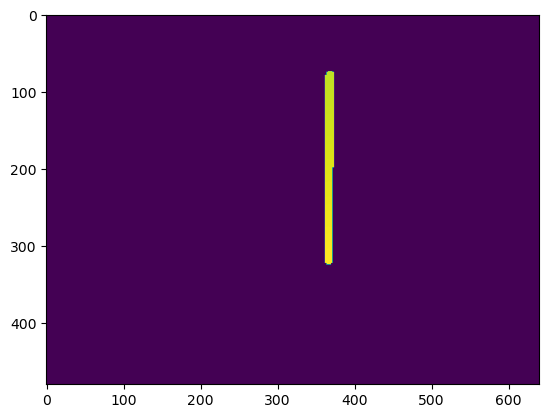

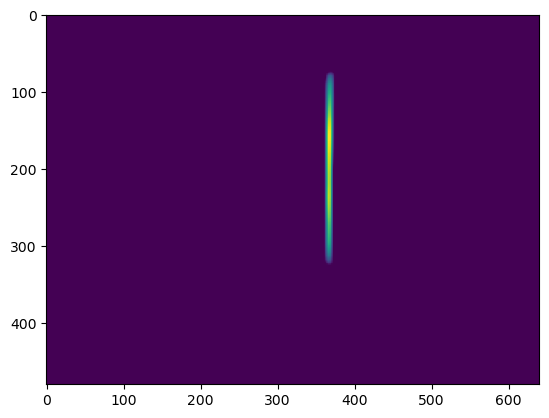

------------------------------------------------------------


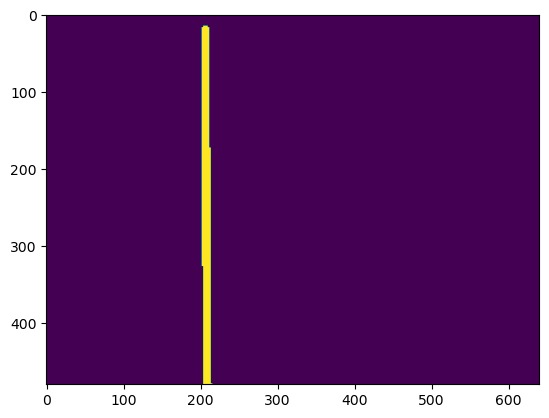

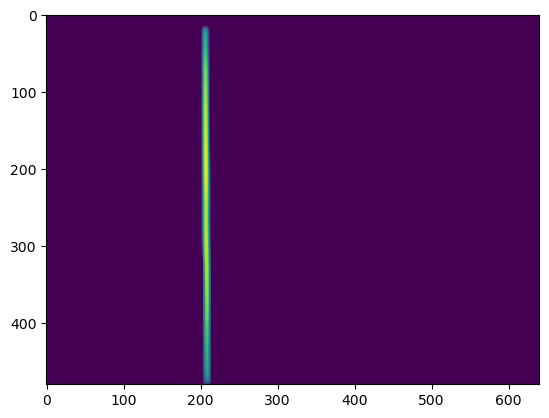

------------------------------------------------------------


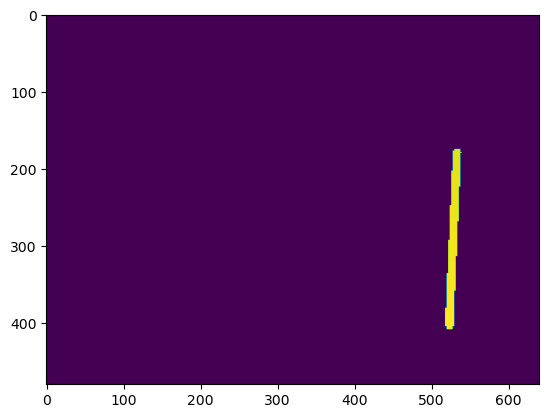

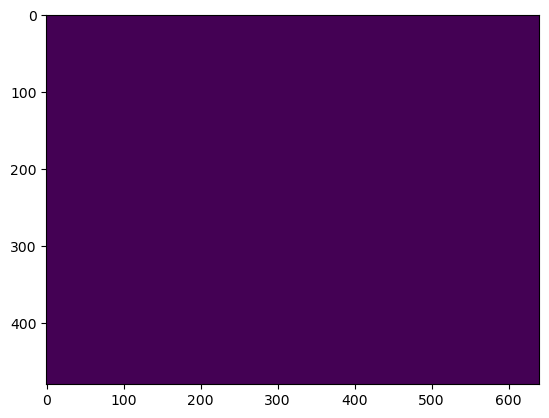

------------------------------------------------------------


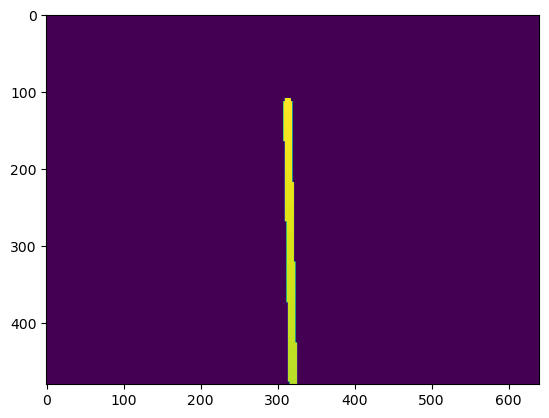

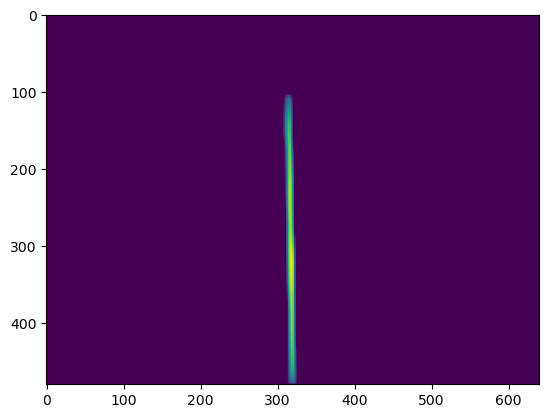

------------------------------------------------------------


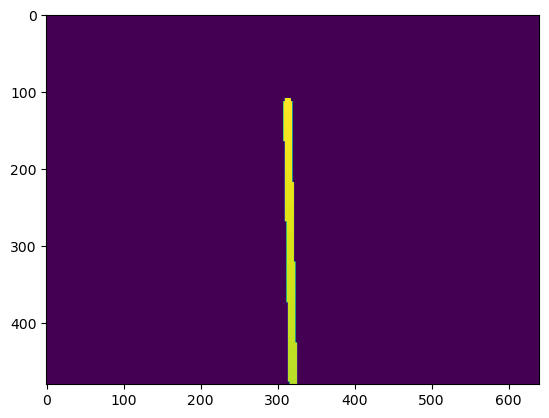

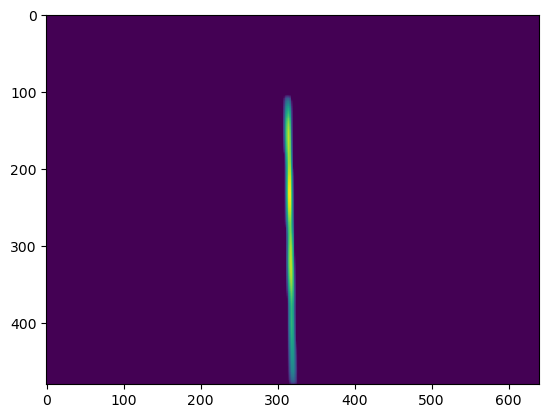

------------------------------------------------------------


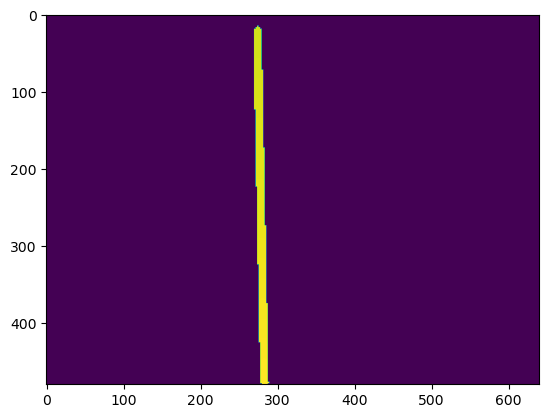

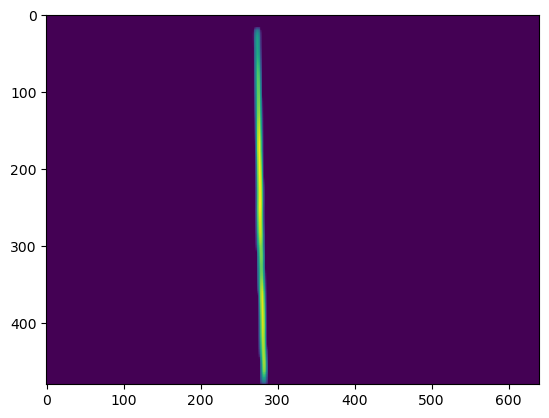

------------------------------------------------------------


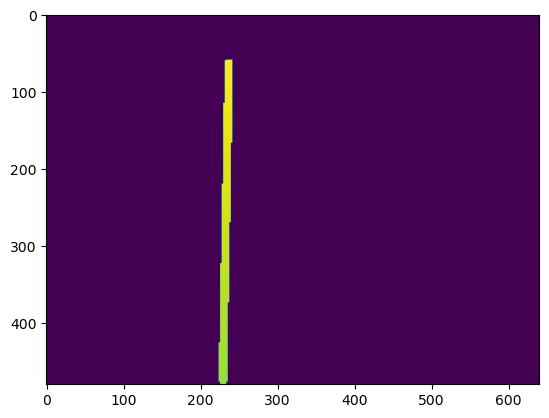

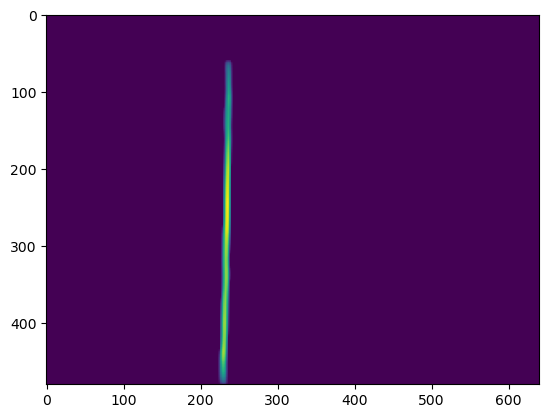

------------------------------------------------------------


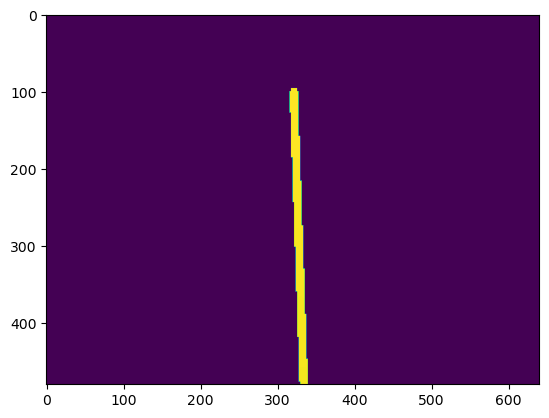

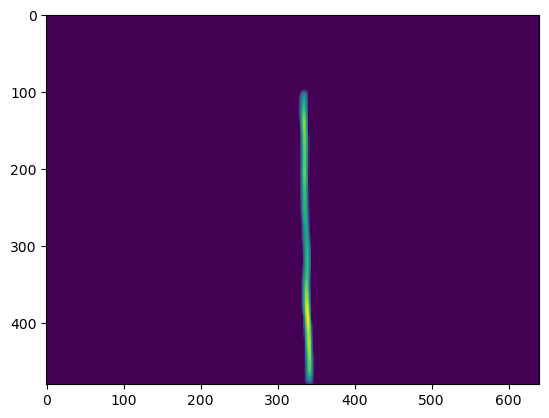

------------------------------------------------------------


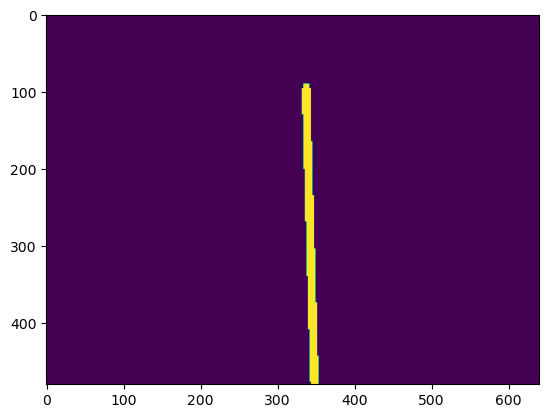

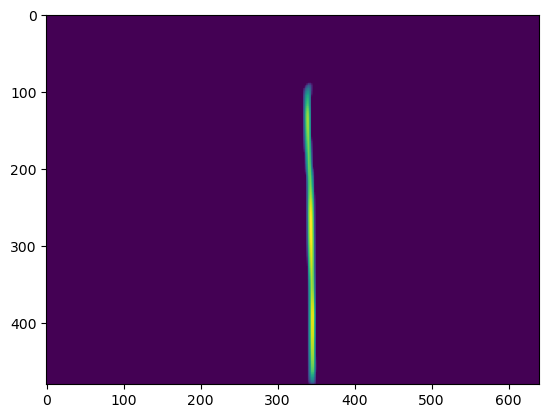

------------------------------------------------------------


In [29]:
with torch.no_grad():
    for b, (images, true_mask) in enumerate(val_loader):
#         Apply the model
        images = images.to(device=device)
        true_mask = true_mask.to(device=device)
        y_val = Model(images)
        
#         todo
#         new_input = torch.cat((images, y_val), axis=1) 
#         print(new_input.shape)
        
        y_val = F.threshold(y_val, 0.2, 0)
    
        
        for j in range(y_val.shape[0]):
            images_buff = inv_resize(images[j])
            RGB_buff = images_buff[0].cpu().numpy()*255
#             print(RGB_buff.shape)
#             RGB_buff = np.transpose(RGB_buff, (1,2,0))
            RGB_buff = np.ascontiguousarray(RGB_buff, dtype=np.uint8)

            DEPTH_buff = images_buff[1].cpu().numpy()*5500
            trueAxis_buff = inv_resize(true_mask[j]).cpu().detach().numpy().transpose(1,2,0)
            predAxis_buff = inv_resize(y_val[j]).cpu().detach().numpy().transpose(1,2,0)
            
            NEW_DEPTH = DEPTH_buff.reshape(DEPTH_buff.shape[0],DEPTH_buff.shape[1],1)
#             new_axis = np.zeros([480,640,1])
#             new_axis[np.where(predAxis_buff > 1)] = NEW_DEPTH[np.where(predAxis_buff > 1)]
            
#             minval = np.min(new_axis[np.nonzero(new_axis)])
            
#             new_axis[np.where(predAxis_buff > 1)] = minval
#             print(minval)
            PC_object = CreatePointCloud(RGB_buff, DEPTH_buff)
            PC_realAxis = CreateAxisCloud(trueAxis_buff)
            PC_predAxis = CreateAxisCloud(predAxis_buff)
#             DrawnAxis = CreateAxisCloud(new_axis/1000)
            
#             o3d.visualization.draw_geometries([PC_object,PC_predAxis])

            plt.figure()
            plt.imshow(trueAxis_buff)
            
            plt.figure()
            plt.imshow(predAxis_buff)
            
#             plt.figure()
#             plt.imshow(new_axis)
            plt.show()
            print('------------------------------------------------------------')

# Save model

In [30]:
# Rename it !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
torch.save(Model.state_dict(), 'Modele/UN1-A_80E_DL.pt')

torch.Size([1, 1, 256, 320])


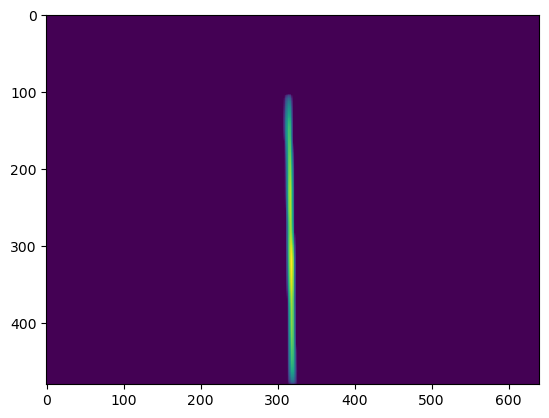

------------------------------------------------------------


In [31]:
num = 10
y = Model(X_validation[num].reshape(1,X_validation[num].shape[0],X_validation[num].shape[1],X_validation[num].shape[2]).to(device))

y = F.threshold(y, 0.2, 0)

print(y.shape)
    

images_buff = inv_resize(X_validation[5])
RGB_buff = images_buff[0].cpu().numpy()*255
RGB_buff = np.ascontiguousarray(RGB_buff, dtype=np.uint8)

DEPTH_buff = images_buff[1].cpu().numpy()*5500
# trueAxis_buff = inv_resize(true_mask[j]).cpu().detach().numpy().transpose(1,2,0)
predAxis_buff = inv_resize(y[0]).cpu().detach().numpy().transpose(1,2,0)

    
NEW_DEPTH = DEPTH_buff.reshape(DEPTH_buff.shape[0],DEPTH_buff.shape[1],1)
#             new_axis = np.zeros([480,640,1])
#             new_axis[np.where(predAxis_buff > 1)] = NEW_DEPTH[np.where(predAxis_buff > 1)]
            
#             minval = np.min(new_axis[np.nonzero(new_axis)])
            
#             new_axis[np.where(predAxis_buff > 1)] = minval
#             print(minval)
PC_object = CreatePointCloud(RGB_buff, DEPTH_buff)
# PC_realAxis = CreateAxisCloud(trueAxis_buff)
PC_predAxis = CreateAxisCloud(predAxis_buff)

#             DrawnAxis = CreateAxisCloud(new_axis/1000)
            
#             o3d.visualization.draw_geometries([PC_object,PC_predAxis])

# plt.figure()
# plt.imshow(trueAxis_buff)
            
plt.figure()
plt.imshow(predAxis_buff)
            
#             plt.figure()
#             plt.imshow(new_axis)
plt.show()
print('------------------------------------------------------------')
